In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

**Modify the previous code to solve the following the problem:**

Consider 2D heat transfer across a plate  of thermal conductivity $k = 50 $ shown in the figure below

Boundary condation
\begin{align}
- k\nabla T \cdot {\bf n} & = 100W/m, & \mbox{ on } & (DA)\\
q_n & = 2 (T-20), & \mbox{ on } & (BC)\\
k\nabla T \cdot {\bf n} & = 0, & \mbox{ on } & (AB)\\
T & = 50, & \mbox{ on } & (CD)\\
k & = 0.935 W/mC\\  
\end{align}
where
$$f(x,y) = 2xy,$$
$$u = 50,$$


In [ ]:
from dolfin import *
from mshr import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

 number of cells =  913


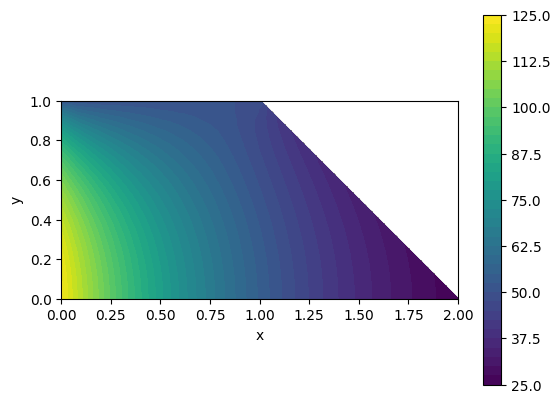

In [ ]:
# Create list of polygonal domain vertices
domain_vertices = [Point(0.0, 0.0),  # A
                   Point(2.0, 0.0),  # B
                   Point(1.0, 1.0),  # C
                   Point(0.0, 1.0),  # D
                   Point(0.0, 0.0)]  # A

# Generate the mesh
domain = Polygon(domain_vertices)
mesh = generate_mesh(domain, 20)
print (" number of cells = ",mesh.num_cells())
plot(mesh)

# Define the Top part of the boundary
class TopBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and abs(x[1] - 1) < DOLFIN_EPS

# Define the Bottom part of the boundary
class BottomBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and abs(x[1]) < DOLFIN_EPS

# Define the Left part of the boundary
class LeftBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and abs(x[0]) < DOLFIN_EPS

# Define the Right part of the boundary
class RightBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0] + x[1] - 2,0)

# Initialize boundary parts
boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)

# Mark the entire boundary as 0
boundary_parts.set_all(0)

# Mark the boundaries as subdomains 1, 2, 3, and 4
Gamma_top = TopBoundary()
Gamma_top.mark(boundary_parts, 1)

Gamma_bottom = BottomBoundary()
Gamma_bottom.mark(boundary_parts, 2)

Gamma_left = LeftBoundary()
Gamma_left.mark(boundary_parts, 3)

Gamma_right = RightBoundary()
Gamma_right.mark(boundary_parts, 4)

# Define thermal conductivity
k = Constant(0.935)

# Define Dirichlet boundary condition
u_f = Constant(50.0)
h = Constant(2.0)
T_0 = Constant(20.0)
g_a = Constant(0.0)
g_b = Constant(100.0)

# Define function space
Vh = FunctionSpace(mesh, 'Lagrange', 1)

# Define boundary conditions
bcs = [DirichletBC(Vh, u_f, boundary_parts, 1)]  # Dirichlet on left boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

# Define variational problem
u = TrialFunction(Vh)
v = TestFunction(Vh)
f = Expression('2*x[0]*x[1]', degree=3)

a = k * inner(grad(u), grad(v)) * dx + h*u*v*ds(4)
L = f*v*dx + g_a*v*ds(2) + g_b*v*ds(3) + h*T_0*v*ds(4)

# Solve variational problem
u = Function(Vh)
solve(a == L, u, bcs)

# Plot solution
p = plot(u)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(p)
plt.show()
